In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import re
from sklearn.utils import shuffle
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ClassificationReport, ClassPredictionError, ROCAUC, ConfusionMatrix

/Users/annariehle/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
def read_lyrics_data(file_name):
    return pd.read_csv(file_name)

In [9]:
def get_vocab_words(genre_df, max_features, ngram_range):
    vocab_set = set()
    vectorizer = TfidfVectorizer(max_features = max_features, ngram_range = ngram_range, max_df = .999, min_df = .00001,\
                                stop_words = 'english')
    
    vectorizer.fit_transform(genre_df.Lyrics)
    genre_vocab = vectorizer.vocabulary_
    vocab_set.update(set(genre_vocab.keys()))
    return vocab_set

In [5]:
from sklearn.linear_model import LogisticRegression
def get_logistic_metrics(features, labels):
    penalty = ['l1', 'l2']
    regs = [2, 1, .1, .01]
    
    hyperparameters = dict(C=regs, penalty=penalty)
    model = LogisticRegression(random_state=0, solver = 'saga',class_weight='balanced', multi_class='multinomial', \
                               max_iter=3000)
    
    clf = GridSearchCV(model, hyperparameters, cv=2, verbose=0, n_jobs = 5)
    grid_model = clf.fit(features, labels)
    return grid_model

In [140]:
from sklearn.svm import LinearSVC
def get_svc_metrics(features, labels):
    penalty = ['l1', 'l2']
    regs = [2, 1, .1, .01]
    loss = ['hinge', 'squared_hinge']
    max_iter = [100,1000,3000]
    
    hyperparameters = dict(C=regs, penalty=penalty, loss=loss, max_iter=max_iter)
    model = LinearSVC()
    
    clf = GridSearchCV(model, hyperparameters, cv=2, verbose=0, n_jobs = 5)
    grid_model = clf.fit(features, labels)
    return grid_model

In [93]:
from sklearn.ensemble import RandomForestClassifier
def get_forest_metrics(features, labels):
    num_trees = [30, 50, 80]
    max_features = ['sqrt', 'log2']
    depth = [11, 13, 15]
    
    hyperparameters = dict(n_estimators=num_trees, max_depth=depth, max_features = max_features)
    model = RandomForestClassifier(min_samples_leaf = int(.05 * len(labels)), random_state=0, class_weight='balanced', max_features='sqrt')
    
    clf = GridSearchCV(model, hyperparameters, cv=2, verbose=0, n_jobs = 5)
    grid_model = clf.fit(features, labels)
    return grid_model

In [109]:
def run_cross_validation(lyrics_df, ngram):
    unique_genres = lyrics_df.Genre.unique()
    
    features = lyrics_df.Lyrics
    labels = lyrics_df.Genre
    vocab_set = set()
    
    for genre in unique_genres: # Get top phrases for each genre
        genre_df = lyrics_df[lyrics_df.Genre == genre]
        vocab = get_vocab_words(genre_df, 300, (ngram, ngram))
        vocab_set.update(vocab)
    
    
    vectorizer = TfidfVectorizer(ngram_range = (ngram, ngram), vocabulary = vocab_set, stop_words = 'english')
    train_features = vectorizer.fit_transform(features)
    
    #logistic_grid = get_logistic_metrics(train_features, labels)   
    #forest_grid = get_forest_metrics(train_features, labels)
    svc_grid = get_svc_metrics(train_features, labels)

    return svc_grid

In [141]:
lyrics = read_lyrics_data("cleaned_lyrics.csv")
logistic_df = []
forest_df = []
svc_df = []

for g in range(1,7):
    run_cross_validation(lyrics, g)
    svc_grid = run_cross_validation(lyrics, g)
    
    #best_logistic = logistic_grid.best_params_
    #best_logistic['gram'] = g
    #best_logistic['score'] = logistic_grid.best_score_
    #logistic_df.append(best_logistic)
    
    #best_forest = forest_grid.best_params_
    #best_forest['gram'] = g
    #best_forest['score'] = forest_grid.best_score_
    #forest_df.append(best_forest)
    
    best_svc = svc_grid.best_params_
    best_svc['gram'] = g
    best_svc['score'] = svc_grid.best_score_
    svc_df.append(best_svc)

/Users/annariehle/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/annariehle/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [415]:
logistic_df = pd.DataFrame(logistic_df)
logistic_df

,C,gram,penalty,score
0,1.00,1,l2,0.533306
1,2.00,2,l2,0.400487
2,2.00,3,l2,0.293258
3,2.00,4,l2,0.226645
4,0.01,5,l2,0.221365
5,0.10,6,l2,0.223396


([<matplotlib.axis.YTick at 0x1c202edfd0>,
 <a list of 12 Text yticklabel objects>)

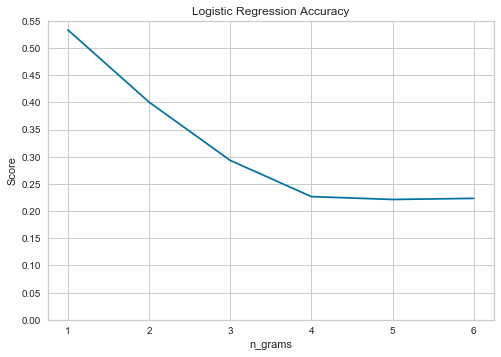

In [132]:
n_grams = [1, 2, 3, 4, 5, 6]
accuracy = [0.533306, 0.400487, 0.293258, 0.226645, 0.221365, 0.223396]
plt.plot(n_grams, accuracy)
plt.xlabel('n_grams')
plt.ylabel('Score')
plt.title('Logistic Regression Accuracy')
plt.ylim(ymin=0)
plt.yticks(np.arange(0,0.6,step=0.05))

In [41]:
X = lyrics.Lyrics
y = lyrics.Genre
X_train, X_test, y_train, y_test = train_test_split(lyrics.Lyrics, lyrics.Genre, test_size=0.2, random_state=42)

In [412]:
lr_tfidf = Pipeline(
    [('vect', TfidfVectorizer(stop_words='english', vocabulary=get_vocab_words(lyrics, 300, (1, 1)))),
     ('clf', LogisticRegression(random_state=0, solver = 'saga',class_weight='balanced', multi_class='multinomial', \
                               max_iter=3000))])

/Users/annariehle/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


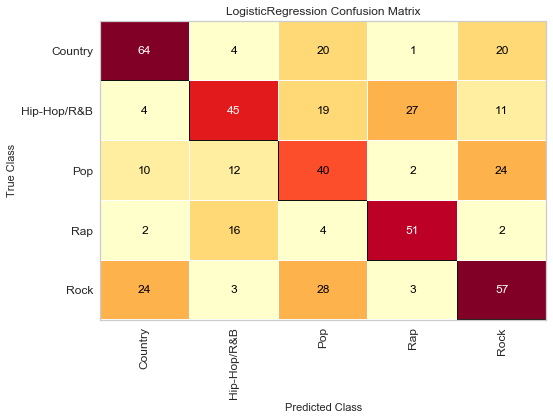

In [413]:
visualizer = ConfusionMatrix(lr_tfidf)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()            

/Users/annariehle/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


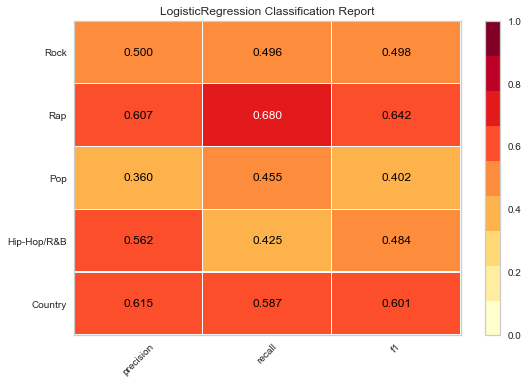

In [410]:
from yellowbrick.classifier import ClassificationReport, ClassPredictionError, ROCAUC, ConfusionMatrix


visualizer = ClassificationReport(lr_tfidf)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

/Users/annariehle/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


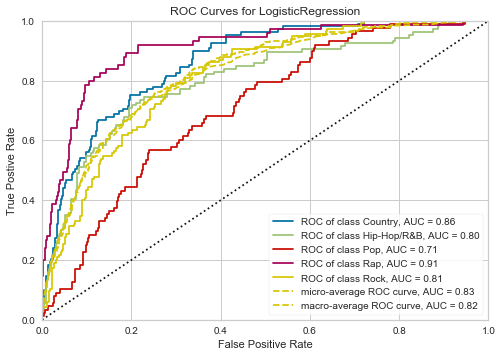

In [411]:

visualizer = ROCAUC(lr_tfidf)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()            

In [97]:
pd.DataFrame({'parameter': ['n_gram', 'max_depth', 'max_features', 'n_estimators'], 'values': ['1-6', '11, 13, 15', 'sqrt, log2', '30, 50, 80']})

,parameter,values
0,n_gram,1-6
1,max_depth,"11, 13, 15"
2,max_features,"sqrt, log2"
3,n_estimators,"30, 50, 80"


In [95]:
forest_df = pd.DataFrame(forest_df)
forest_df

,gram,max_depth,max_features,n_estimators,score
0,1,11,sqrt,80,0.471568
1,2,11,sqrt,80,0.266450
2,3,11,sqrt,30,0.212429
3,4,11,sqrt,30,0.212429
4,5,11,sqrt,30,0.212429
5,6,11,sqrt,30,0.212429


([<matplotlib.axis.YTick at 0x1a1a901dd8>,
 <a list of 10 Text yticklabel objects>)

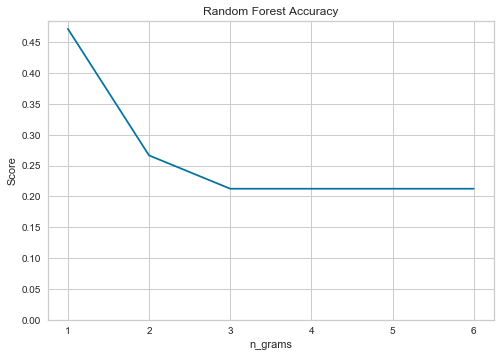

In [96]:
n_grams = [1, 2, 3, 4, 5, 6]
accuracy = [0.471568, 0.266450, 0.212429, 0.212429, 0.212429, 0.212429]
plt.plot(n_grams, accuracy)
plt.xlabel('n_grams')
plt.ylabel('Score')
plt.title('Random Forest Accuracy')
plt.ylim(ymin=0)
plt.yticks(np.arange(0,0.5,step=0.05))

In [91]:
rf_tfidf = Pipeline(
    [('vect', TfidfVectorizer(stop_words='english', vocabulary=get_vocab_words(lyrics, 300, (1, 1)))),
     ('clf', RandomForestClassifier(min_samples_leaf = int(.05 * len(lyrics.Genre)), random_state=0, class_weight='balanced', max_features='sqrt', max_depth=11, n_estimators=80))])

/Users/annariehle/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


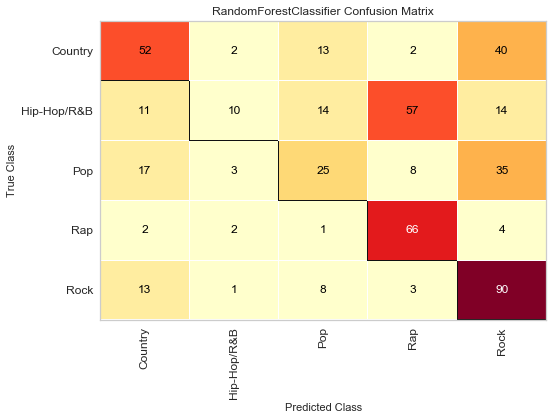

In [98]:
visualizer = ConfusionMatrix(rf_tfidf)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()            

/Users/annariehle/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


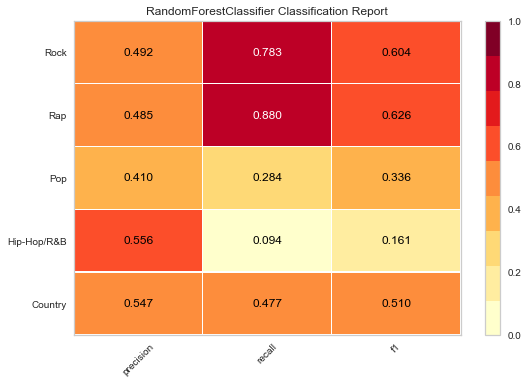

In [99]:
visualizer = ClassificationReport(rf_tfidf)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

/Users/annariehle/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


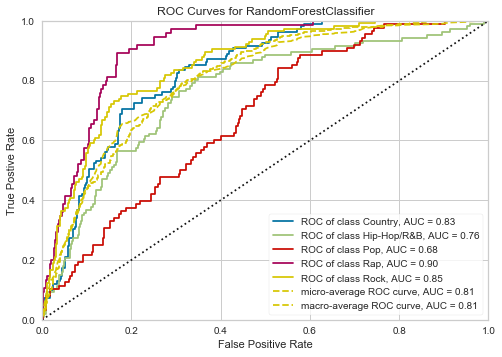

In [100]:

visualizer = ROCAUC(rf_tfidf)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()            

In [142]:
svc_df = pd.DataFrame(svc_df)
svc_df

,C,gram,loss,max_iter,penalty,score
0,0.1,1,squared_hinge,100,l2,0.536556
1,0.1,2,hinge,1000,l2,0.405768
2,1.0,3,squared_hinge,100,l2,0.292445
3,1.0,4,squared_hinge,100,l2,0.226645
4,1.0,5,hinge,3000,l2,0.225020
5,2.0,6,squared_hinge,100,l2,0.220959


([<matplotlib.axis.YTick at 0x1a1c51fd30>,
 <a list of 12 Text yticklabel objects>)

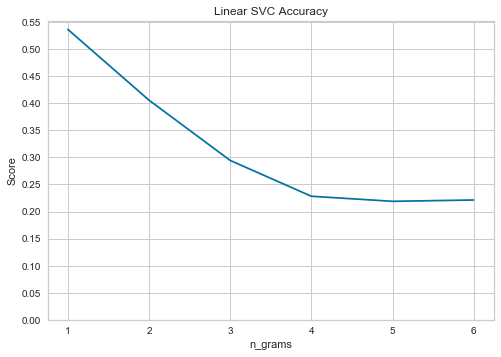

In [118]:
n_grams = [1, 2, 3, 4, 5, 6]
accuracy = [0.536556, 0.405768, 0.294476, 0.228270, 0.218928, 0.221365]
plt.plot(n_grams, accuracy)
plt.xlabel('n_grams')
plt.ylabel('Score')
plt.title('Linear SVC Accuracy')
plt.ylim(ymin=0)
plt.yticks(np.arange(0,0.6,step=0.05))

In [143]:
svc_tfidf = Pipeline(
    [('vect', TfidfVectorizer(stop_words='english', vocabulary=get_vocab_words(lyrics, 300, (1, 1)))),
     ('clf', LinearSVC(C=0.10, loss='hinge', max_iter=100, penalty='l2'))])

/Users/annariehle/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/annariehle/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


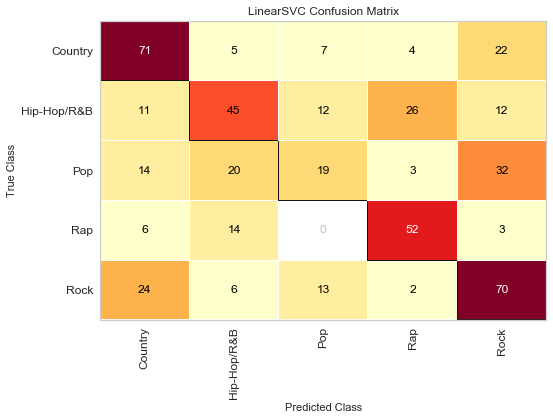

In [144]:
visualizer = ConfusionMatrix(svc_tfidf)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()            

/Users/annariehle/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/annariehle/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


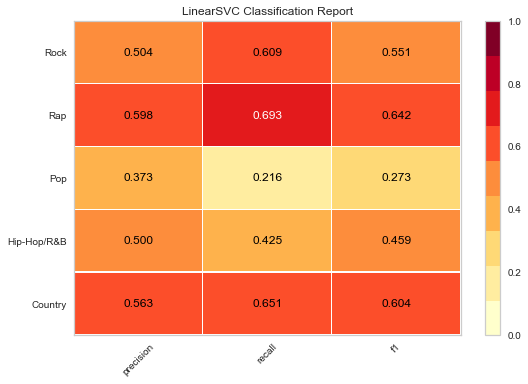

In [145]:
visualizer = ClassificationReport(svc_tfidf)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

/Users/annariehle/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


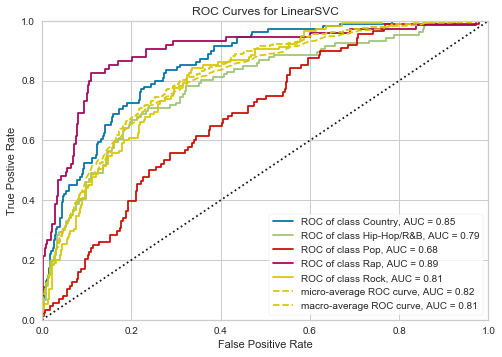

In [131]:

visualizer = ROCAUC(svc_tfidf)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()            

In [ ]:
N = 3
counts = (0.5776274645337546, 0.5768358513544649, 0.5585876040946645)
tfidf = (0.6157401007208453, 0.6092426187419769, 0.5995358941443666)

fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.35        # the width of the bars

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
p1 = ax.bar(ind, counts, width)
p2 = ax.bar(ind + width, tfidf, width)

ax.set_title('Linear SVC: Impact of Limiting Features')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Baseline', 'No Stopwords', 'Max Features'))

ax.legend((p1[0], p2[0]), ('Count Vectorizer', 'TF-IDF'))
ax.autoscale_view()

plt.show()

In [3]:
precisions = pd.DataFrame({"Genre":["Country", "Country", "Country", "Country", "Hip-Hop/R&B", "Hip-Hop/R&B", "Hip-Hop/R&B", "Hip-Hop/R&B", "Pop", "Pop", "Pop", "Pop", "Rap", "Rap", "Rap", "Rap", "Rock", "Rock", "Rock", "Rock"], "Model": ["Linear SVC", "Logistc Regression", "Multinomial Naive Bayes", "Random Forest", "Linear SVC", "Logistc Regression", "Multinomial Naive Bayes", "Random Forest", "Linear SVC", "Logistc Regression", "Multinomial Naive Bayes", "Random Forest", "Linear SVC", "Logistc Regression", "Multinomial Naive Bayes", "Random Forest", "Linear SVC", "Logistc Regression", "Multinomial Naive Bayes", "Random Forest"], "Precision": [0.57, 0.62, 0.58, 0.55, 0.57, 0.56, 0.70, 0.56, 0.35, 0.36, 0.46, 0.41, 0.71, 0.61, 0.65, 0.49, 0.50, 0.50, 0.60, 0.49]})

Text(0.5,1,'Precision by Genre')

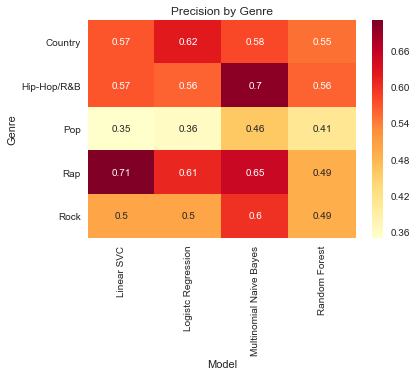

In [5]:
import seaborn as sns
precisions_hm = precisions.pivot(index='Genre', columns='Model', values='Precision')
sns.heatmap(precisions_hm, annot=True, cmap='YlOrRd')
plt.yticks(rotation=0)
plt.title("Precision by Genre")

Text(0.5,1,'Recall by Genre')

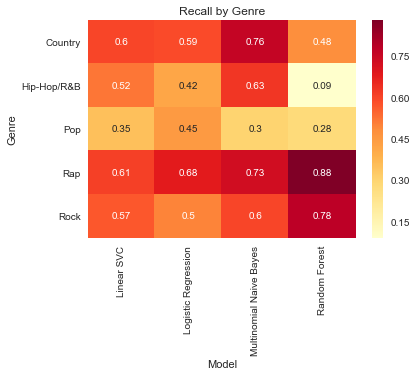

In [6]:
import seaborn as sns
recalls = pd.DataFrame({'Genre': ['Country', 'Country', 'Country', 'Country', 'Hip-Hop/R&B', 'Hip-Hop/R&B', 'Hip-Hop/R&B', 'Hip-Hop/R&B', 'Pop', 'Pop', 'Pop', 'Pop', 'Rap', 'Rap', 'Rap', 'Rap', 'Rock', 'Rock', 'Rock', 'Rock'], 'Model': ['Logistic Regression', 'Random Forest', 'Linear SVC', 'Multinomial Naive Bayes', 'Logistic Regression', 'Random Forest', 'Linear SVC', 'Multinomial Naive Bayes', 'Logistic Regression', 'Random Forest', 'Linear SVC', 'Multinomial Naive Bayes', 'Logistic Regression', 'Random Forest', 'Linear SVC', 'Multinomial Naive Bayes', 'Logistic Regression', 'Random Forest', 'Linear SVC', 'Multinomial Naive Bayes'], 'Recall': [0.59, 0.48, 0.60, 0.76, 0.42, 0.09, 0.52, 0.63, 0.45, 0.28, 0.35, 0.30, 0.68, 0.88, 0.61, 0.73, 0.50, 0.78, 0.57, 0.60]})
recalls_hm = recalls.pivot(index='Genre', columns='Model', values='Recall')
sns.heatmap(recalls_hm, annot=True, cmap='YlOrRd')
plt.yticks(rotation=0)
plt.title("Recall by Genre")

In [153]:
songs_to_remove = []
spanish_words = [' que ', ' en ', ' te ', ' por ', ' se ', ' cuerpo ', ' es ', ' el ', ' voy ', ' una ', ' pero ']
for index, row in data.iterrows():
    if ('Japanese') in row['Song']:
        songs_to_remove.append(row['Song'])
    if ('Mandarin') in row['Song']:
        songs_to_remove.append(row['Song'])
    for word in spanish_words:
        if word in row['Lyrics']:
            if row['Song'] not in songs_to_remove:
                songs_to_remove.append(row['Song'])
    for character in asian_characters:
        if character in row['Lyrics']:
            if row['Song'] not in songs_to_remove:
                songs_to_remove.append(row['Song'])
len(songs_to_remove)

73

Text(0.5,0,'n_grams')

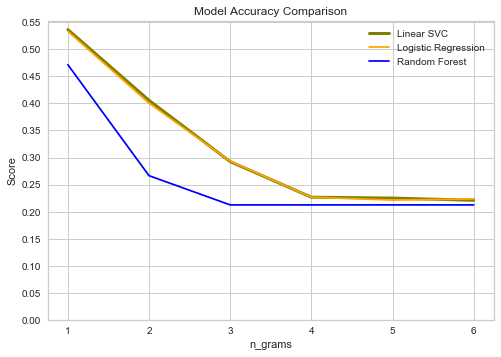

In [192]:
model_accuracies = pd.DataFrame({'n_grams': [1, 2, 3, 4, 5, 6], 'Linear SVC': [0.536556, 0.405768, 0.292445, 0.226645, 0.225020, 0.220959], 'Logistic Regression': [0.533306, 0.400487, 0.293258, 0.226645, 0.221365, 0.223396], 'Random Forest': [0.471568, 0.266450, 0.212429, 0.212429, 0.212429, 0.212429]})
plt.plot('n_grams', 'Linear SVC', data=model_accuracies, color='olive', linewidth=3)
plt.plot('n_grams', 'Logistic Regression', data=model_accuracies, color='orange')
plt.plot('n_grams', 'Random Forest', data=model_accuracies, color='blue')
plt.legend()
plt.yticks(np.arange(0,0.6,step=0.05))
plt.title("Model Accuracy Comparison")
plt.ylabel("Score")
plt.xlabel("n_grams")

In [154]:
eng_data = (data[~data.Song.isin(songs_to_remove)])

In [333]:
train_genres = pd.get_dummies(y_train)

In [334]:
count_vect = CountVectorizer(max_features=2500, stop_words='english')
count_vect_df = pd.DataFrame(count_vect.fit_transform(X_train).todense(), columns=count_vect.get_feature_names())
test_corr = pd.concat([train_genres, count_vect_df], axis=1).corr()

Text(0.5,1,'Words Highly Correlated with Genres')

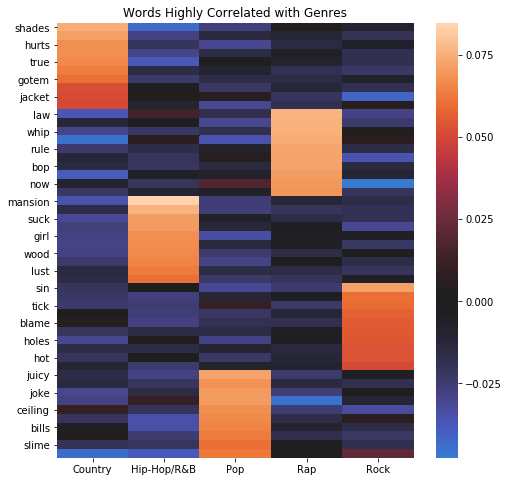

In [294]:
genres=['Country', 'Hip-Hop/R&B', 'Pop', 'Rap', 'Rock']
data_for_heatmap = test_corr[~test_corr.columns.isin(genres)][['Country', 'Hip-Hop/R&B', 'Pop', 'Rap', 'Rock']]
import seaborn
fig, ax = plt.subplots(figsize=(8,8)) 
seaborn.heatmap(data_for_heatmap, center=0)
plt.title("Words Highly Correlated with Genres")
#plt.savefig("word_corr.jpg")

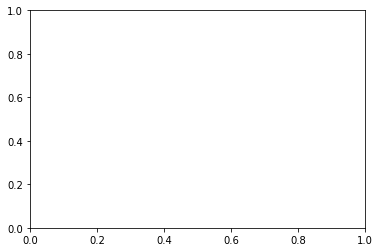

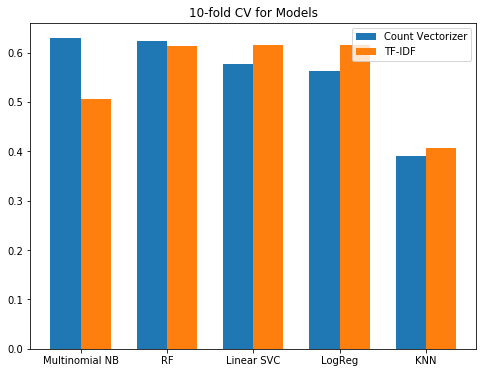

In [65]:
N = 5
counts = (0.62911688226194, 0.6238356209473026, 0.5776274645337546, 0.561811658602416, 0.39076067278891413)
tfidf = (0.5050738948685034, 0.6140630657318719, 0.6161433132549948, 0.6157401007208453, 0.40696652513083836)

fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.35        # the width of the bars

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
p1 = ax.bar(ind, counts, width)
p2 = ax.bar(ind + width, tfidf, width)

ax.set_title('10-fold CV for Models')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Multinomial NB', 'RF', 'Linear SVC', 'LogReg', 'KNN'))

ax.legend((p1[0], p2[0]), ('Count Vectorizer', 'TF-IDF'))
ax.autoscale_view()

plt.show()

In [15]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

0.637223922846516

In [409]:
### Diagnostics and Vizualizations
from sklearn.metrics import classification_report

targetnames = list(set(y_test))
classification_report(y_test, predicted, target_names = targetnames)

TypeError: 'list' object is not callable